In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import time
import copy
import os


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
# FashionMNIST is grayscale and 28x28, but VGG16 expects RGB images of size 224x224
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # convert grayscale to RGB by repeating channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # convert grayscale to RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [19]:
# load the FashionMNIST dataset
print("Loading FashionMNIST dataset...")
trainset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform_train
)

testset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transform_test
)

# create data loaders
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Loading FashionMNIST dataset...


In [20]:
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.pause(0.001)


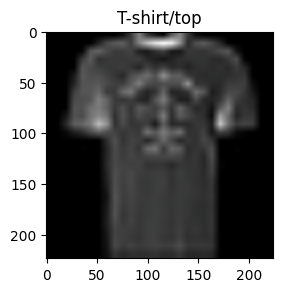

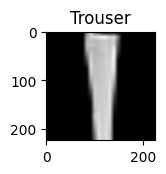

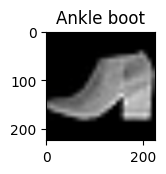

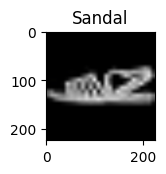

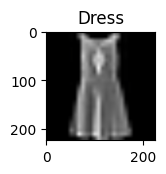

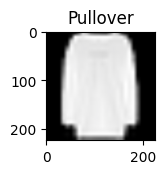

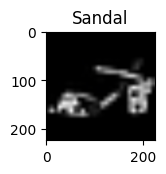

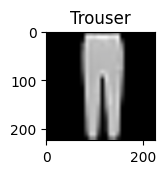

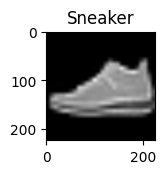

<Figure size 640x480 with 0 Axes>

In [21]:
# visualize examples from dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    imshow(images[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()


In [22]:
# load and modify VGG16 Model
print("Loading pre-trained VGG16 model...")
model = models.vgg16(pretrained=True)

# modify the final fully connected layer to match FashionMNIST (10 classes)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)

# move model to device
model = model.to(device)

Loading pre-trained VGG16 model...


In [23]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
                dataloader = trainloader
            else:
                model.eval()   # set model to evaluate mode
                dataloader = testloader
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            # deep copy the model if best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [26]:
print("Starting training...")
num_epochs = 10
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Starting training...
Epoch 1/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.3531 Acc: 0.8738


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2679 Acc: 0.9060

Epoch 2/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.2078 Acc: 0.9248


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2139 Acc: 0.9236

Epoch 3/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.1698 Acc: 0.9397


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.1838 Acc: 0.9350

Epoch 4/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.1467 Acc: 0.9469


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.1749 Acc: 0.9368

Epoch 5/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.1281 Acc: 0.9533


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.1894 Acc: 0.9331

Epoch 6/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.1081 Acc: 0.9601


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.1763 Acc: 0.9413

Epoch 7/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.0930 Acc: 0.9666


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2007 Acc: 0.9336

Epoch 8/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.0567 Acc: 0.9804


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.1745 Acc: 0.9461

Epoch 9/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.0496 Acc: 0.9826


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.1783 Acc: 0.9462

Epoch 10/10
----------


train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 0.0457 Acc: 0.9842


val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.1835 Acc: 0.9461

Training complete in 79m 34s
Best val Acc: 0.9462


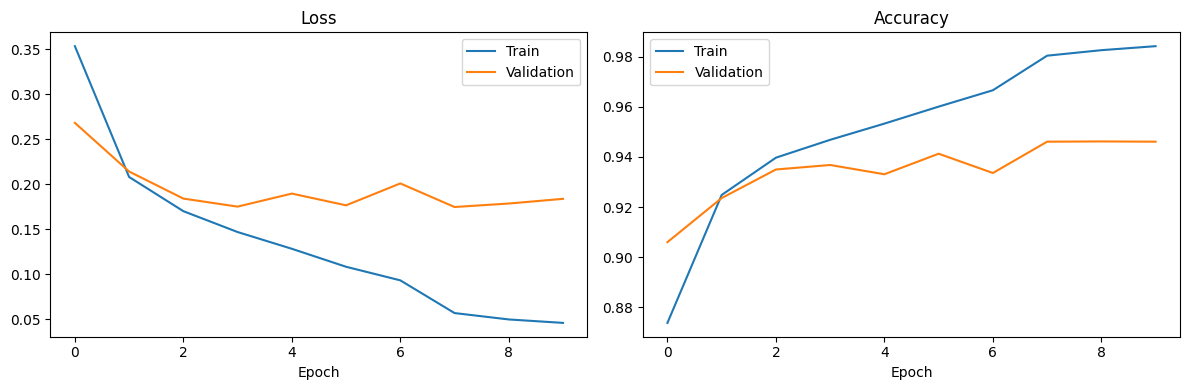

In [27]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# function to visualize model predictions
def visualize_model_predictions(model, dataloader, class_names, num_images=25):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 12))  # adjust grid size depending on num_images

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidences, _ = torch.max(probs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                ax = plt.subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), images_shown + 1)
                inp = inputs[i].cpu().numpy().transpose((1, 2, 0))
                inp = np.clip(inp * 0.229 + 0.485, 0, 1)  # unnormalize (ImageNet)
                ax.imshow(inp)
                pred_label = class_names[preds[i]]
                true_label = class_names[labels[i]]
                confidence = confidences[i].item() * 100

                if pred_label == true_label:
                    color = 'green'
                else:
                    color = 'red'

                ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', color=color, fontsize=8)
                ax.axis('off')
                images_shown += 1

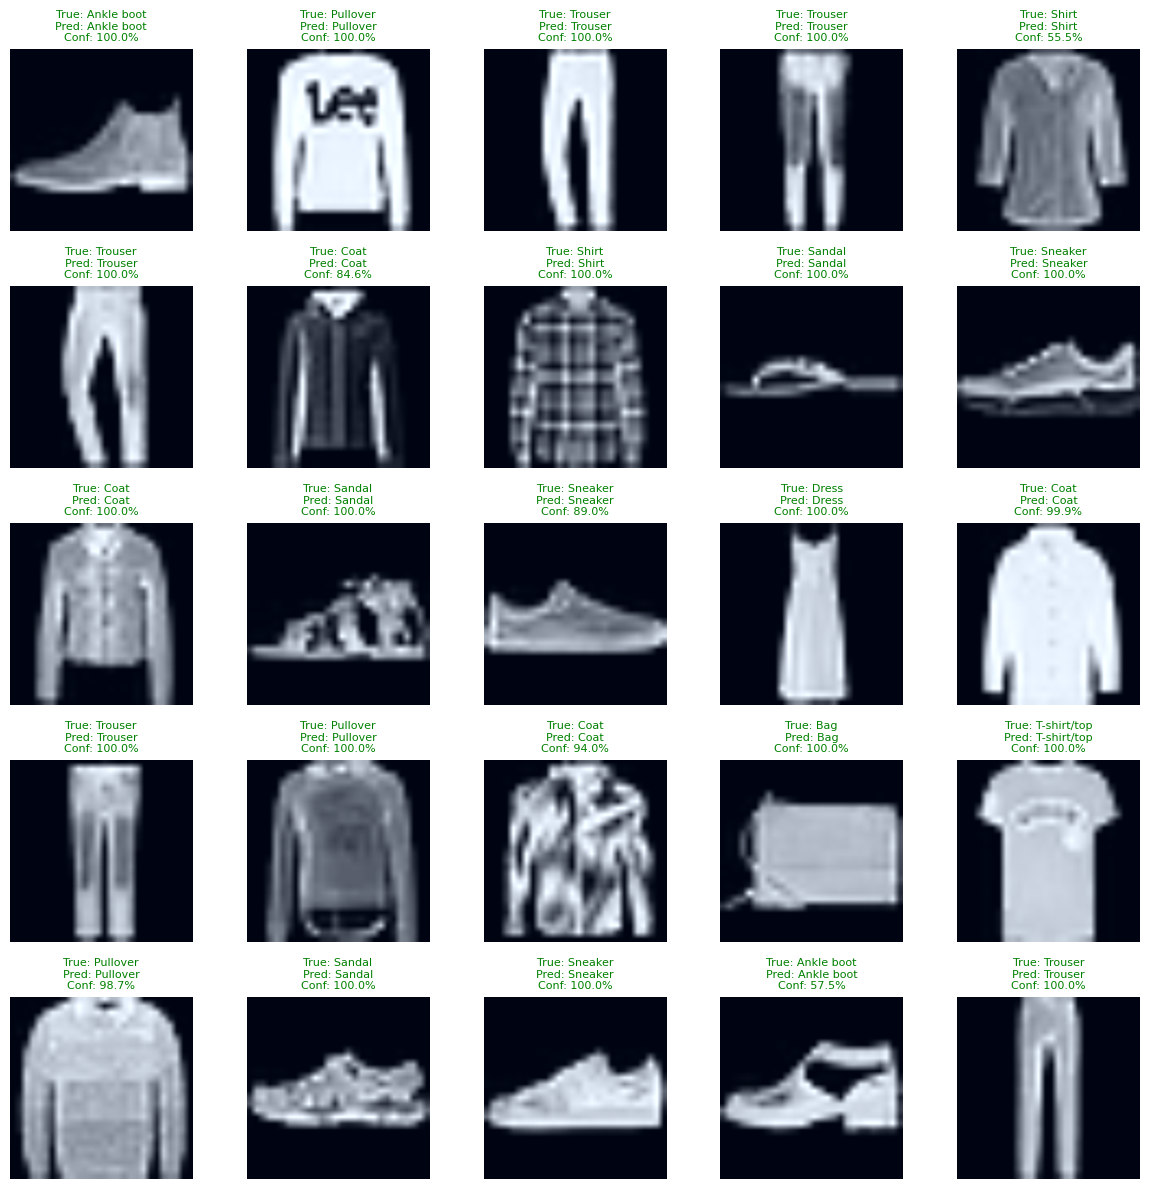

In [29]:
# visualize some predictions
visualize_model_predictions(model, testloader, class_names, num_images=25)


In [30]:
# save the model
torch.save(model.state_dict(), 'vgg16_fashionmnist.pth')
print("Model saved as 'vgg16_fashionmnist.pth'")

Model saved as 'vgg16_fashionmnist.pth'


In [31]:
# calculate overall test accuracy
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


Accuracy on the test set: 94.62%


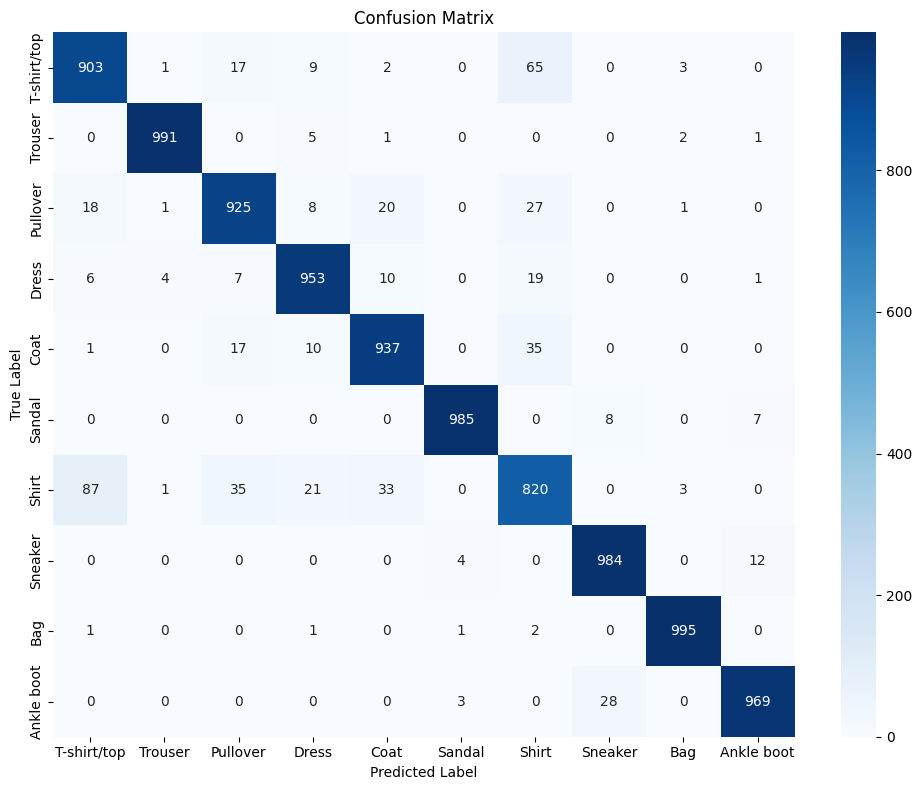

In [32]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# get predictions on the test set
y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [33]:
# generate classification report
from sklearn.metrics import classification_report, accuracy_score

y_pred = []
y_true = []
running_loss = 0.0

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# calculate test set loss
test_loss = running_loss / len(testloader.dataset)
test_accuracy = accuracy_score(y_true, y_pred)

# print the test loss and accuracy
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2%}')

# generate and print the detailed classification report
print('\nClassification Report:')
report = classification_report(y_true, y_pred, 
                              target_names=class_names,
                              digits=4,
                              output_dict=False)
print(report)

# save the classification report as CSV
import pandas as pd
report_dict = classification_report(y_true, y_pred, 
                                   target_names=class_names,
                                   digits=4,
                                   output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('classification_report.csv')
print("Classification report saved as 'classification_report.csv'")

Test Loss: 0.1783 - Test Accuracy: 94.62%

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.8888    0.9030    0.8958      1000
     Trouser     0.9930    0.9910    0.9920      1000
    Pullover     0.9241    0.9250    0.9245      1000
       Dress     0.9464    0.9530    0.9497      1000
        Coat     0.9342    0.9370    0.9356      1000
      Sandal     0.9919    0.9850    0.9885      1000
       Shirt     0.8471    0.8200    0.8333      1000
     Sneaker     0.9647    0.9840    0.9743      1000
         Bag     0.9910    0.9950    0.9930      1000
  Ankle boot     0.9788    0.9690    0.9739      1000

    accuracy                         0.9462     10000
   macro avg     0.9460    0.9462    0.9461     10000
weighted avg     0.9460    0.9462    0.9461     10000

Classification report saved as 'classification_report.csv'
